In [6]:
from exp import *

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [8]:
dm = DatasetManager('2017',224,'all','2017')

In [220]:
def reload_dataset(dm,segmented=False, seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.0, max_lighting=0.0,p_affine=1, max_warp=0)
#     tfms = [[],[]]
    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name + ('_segmented' if segmented else ''),
                   valid=dm.get_dataset_path('valid_images').name +('_segmented' if segmented else ''))\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm,segmented=True)

In [213]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


In [233]:
def train_and_return_metrics(data,seed,epochs):
    random_seed(seed,True)
    learner = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)
    
        
    random_seed(seed,True)
    learner.fit_one_cycle(4,max_lr=slice(3e-3))
    accuracies = list(map(lambda x: x[1], learner.recorder.metrics))
    
    #Unfreeze
    learner.unfreeze()
    random_seed(seed,True)
    learner.fit_one_cycle(epochs, max_lr=slice(3e-4))
    
    accuracies += list(map(lambda x: x[1], learner.recorder.metrics))


    return accuracies

# Baseline with Resnet 50

In [221]:
data = reload_dataset(dm)

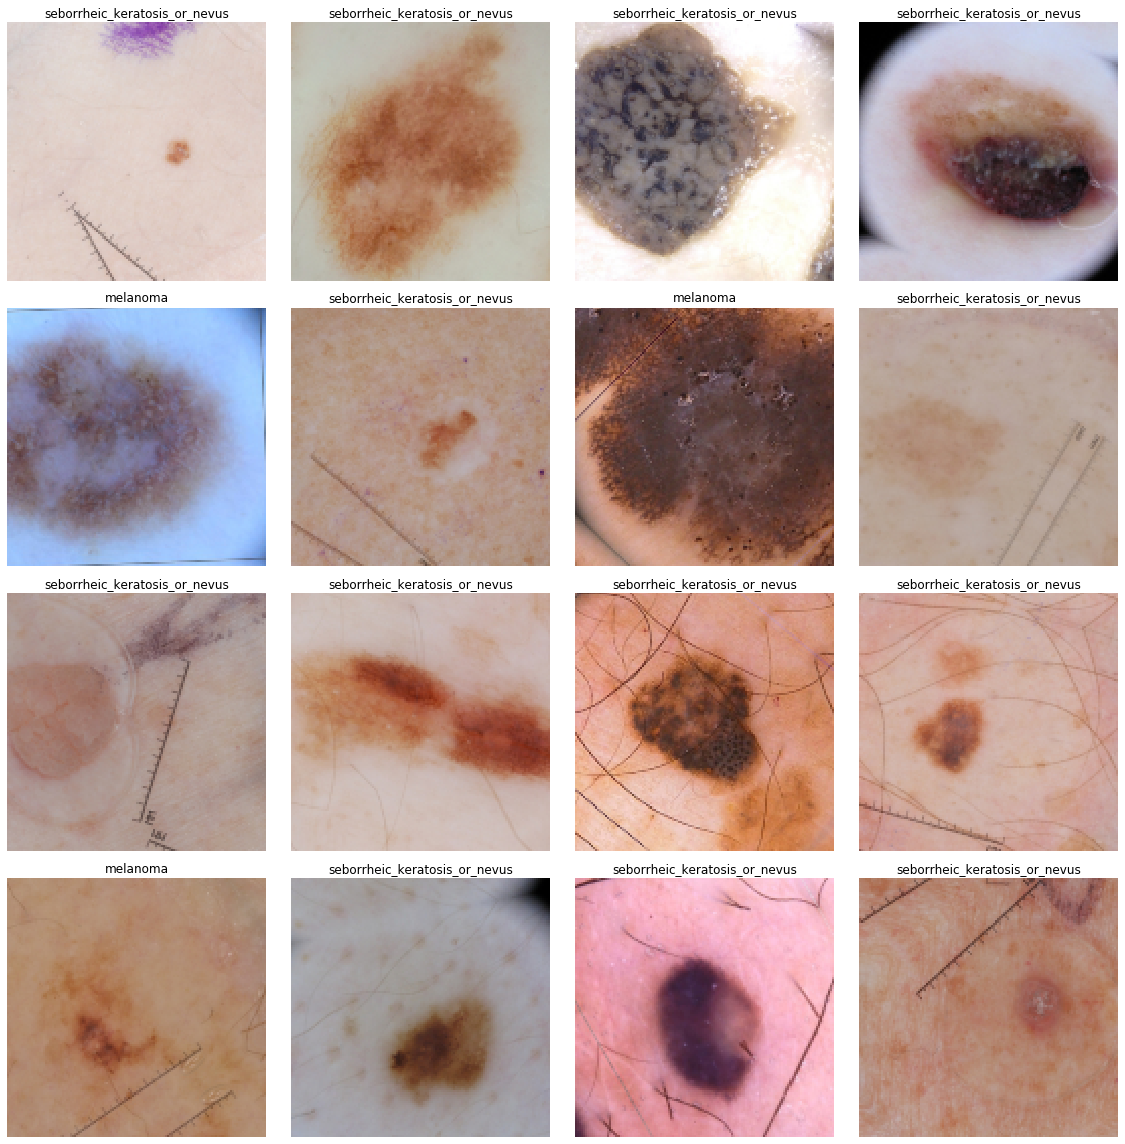

In [222]:
data.show_batch()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.057071,0.669157,0.220000,0.780000,0.692222,00:05
1,0.618928,0.523040,0.206667,0.793333,0.695278,00:05
2,0.516425,0.494786,0.193333,0.806667,0.721389,00:05
3,0.443267,0.445440,0.180000,0.820000,0.765000,00:05


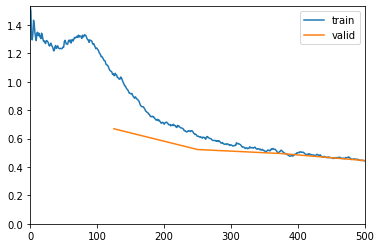

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.239346,0.431048,0.173333,0.826667,0.766944,00:07
1,0.165982,0.434541,0.173333,0.826667,0.766389,00:07
2,0.111791,0.446483,0.180000,0.820000,0.760833,00:07
3,0.345802,0.443360,0.180000,0.820000,0.779722,00:07
4,0.385865,0.431989,0.166667,0.833333,0.772500,00:07
5,0.390452,0.424047,0.173333,0.826667,0.782500,00:07
6,0.399856,0.429282,0.173333,0.826667,0.781389,00:07
7,0.420111,0.414273,0.173333,0.826667,0.802222,00:07
8,0.421582,0.445590,0.180000,0.820000,0.769167,00:07
9,0.407370,0.425580,0.166667,0.833333,0.790833,00:07


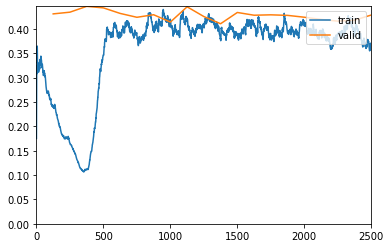

[tensor(0.7800),
 tensor(0.7933),
 tensor(0.8067),
 tensor(0.8200),
 tensor(0.8267),
 tensor(0.8267),
 tensor(0.8200),
 tensor(0.8200),
 tensor(0.8333),
 tensor(0.8267),
 tensor(0.8267),
 tensor(0.8267),
 tensor(0.8200),
 tensor(0.8333),
 tensor(0.8200),
 tensor(0.8333),
 tensor(0.8267),
 tensor(0.8333),
 tensor(0.8200),
 tensor(0.8200),
 tensor(0.8133),
 tensor(0.8333),
 tensor(0.8333),
 tensor(0.8267)]

In [208]:
train_and_return_metrics(data,1,20)

# Segmented 

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.981878,0.974596,0.266667,0.733333,0.590833,00:05
1,0.626034,0.643349,0.206667,0.793333,0.653889,00:05
2,0.513471,0.497557,0.180000,0.820000,0.760556,00:05
3,0.445940,0.469977,0.193333,0.806667,0.759722,00:05


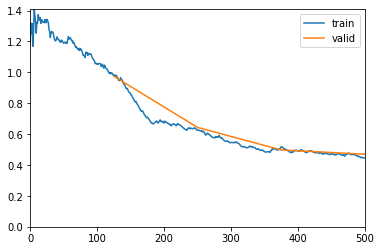

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.238220,0.465435,0.193333,0.806667,0.760556,00:07
1,0.164298,0.452235,0.186667,0.813333,0.773611,00:07
2,0.103574,0.479603,0.186667,0.813333,0.758889,00:07
3,0.343335,0.474917,0.200000,0.800000,0.763611,00:07
4,0.391908,0.467556,0.206667,0.793333,0.760278,00:07
5,0.394876,0.457365,0.186667,0.813333,0.775278,00:07
6,0.404351,0.459640,0.186667,0.813333,0.767778,00:07
7,0.432658,0.470419,0.186667,0.813333,0.765000,00:07
8,0.419932,0.458345,0.206667,0.793333,0.778055,00:07
9,0.415880,0.455922,0.200000,0.800000,0.773055,00:07


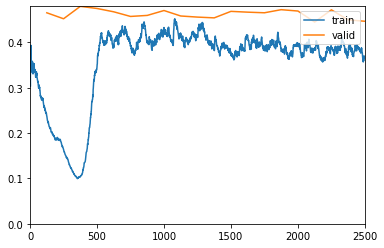

[tensor(0.7333),
 tensor(0.7933),
 tensor(0.8200),
 tensor(0.8067),
 tensor(0.8067),
 tensor(0.8133),
 tensor(0.8133),
 tensor(0.8000),
 tensor(0.7933),
 tensor(0.8133),
 tensor(0.8133),
 tensor(0.8133),
 tensor(0.7933),
 tensor(0.8000),
 tensor(0.8000),
 tensor(0.8067),
 tensor(0.8000),
 tensor(0.7933),
 tensor(0.8000),
 tensor(0.8067),
 tensor(0.8067),
 tensor(0.8133),
 tensor(0.8000),
 tensor(0.7933)]

In [209]:
data = reload_dataset(dm,segmented=True)

train_and_return_metrics(data,1,20)

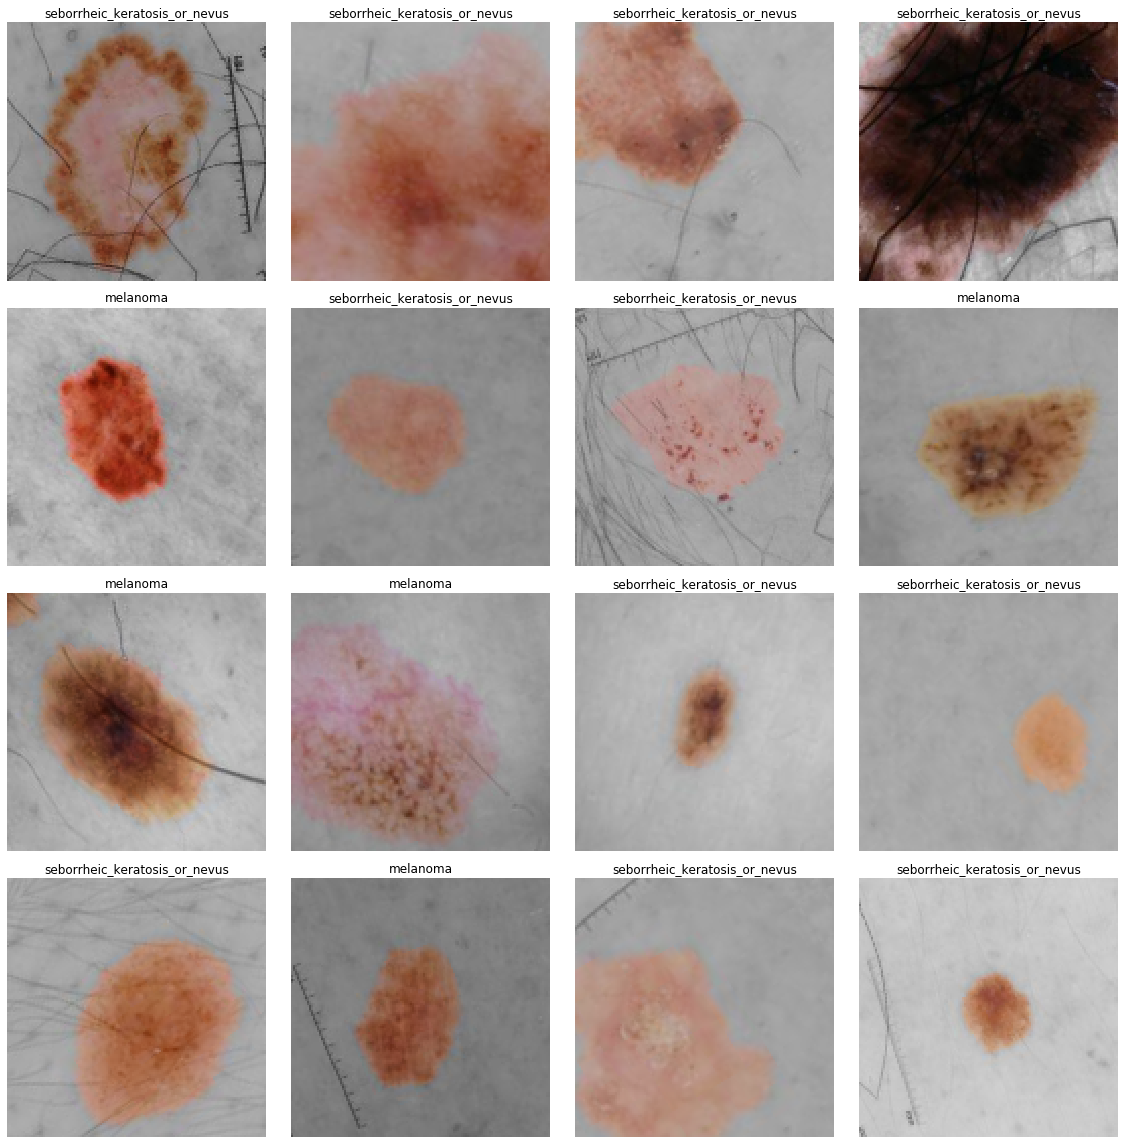

In [211]:
data.show_batch()

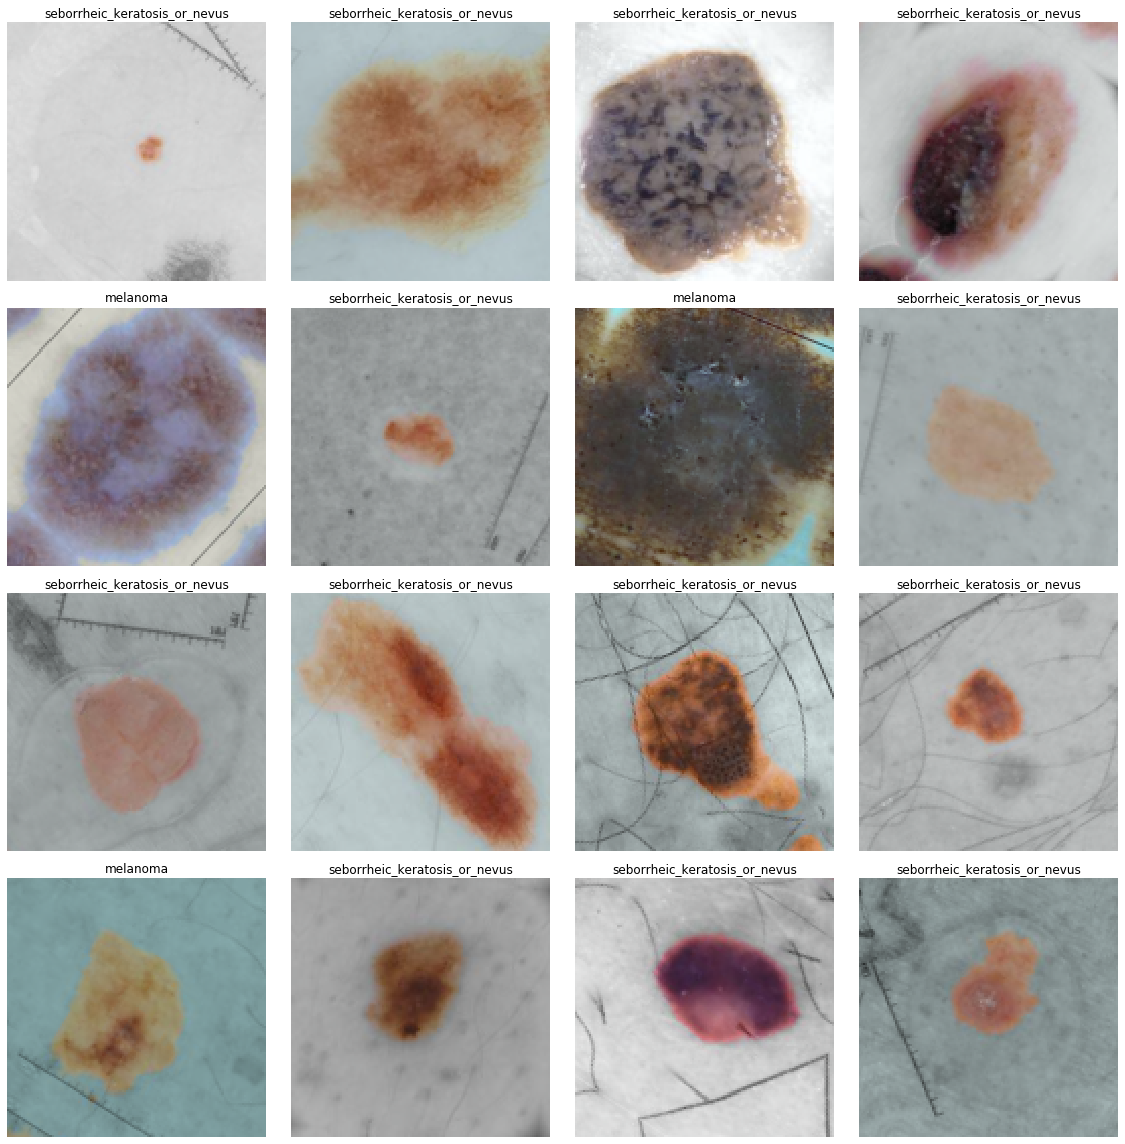

In [226]:
data = reload_dataset(dm,segmented=True,seed=seed)   
add_shades_of_gray(data)
data.show_batch()

# Comparison for various seeds

In [234]:
results_file_name = 'segmentation_analysis_seed'
columns = ['Baseline','Segmented','Baseline SOG','Segmented SOG']


In [235]:
def write_results(seed,*args):
    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    
    for epoch in zip(*args):
        line = ''
        for idx, variant in enumerate(epoch):
            line += str(variant.item())
            if idx != (len(epoch) - 1): 
                line += ','
            else: 
                line += '\n'
        
        f.write(line)


    f.close()

In [236]:
def add_shades_of_gray(data):
    color_constancy_tfm = correct_color_shades_of_gray(gamma=2.2, order=0,p=6)
    data.train_ds.tfms.insert(0,color_constancy_tfm);
    data.valid_ds.tfms.insert(0,color_constancy_tfm);
    

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.028217,0.695972,0.253333,0.746667,0.619444,00:05
1,0.616737,0.453572,0.180000,0.820000,0.745278,00:05
2,0.487817,0.459028,0.200000,0.800000,0.743611,00:05
3,0.434128,0.437357,0.186667,0.813333,0.758889,00:05


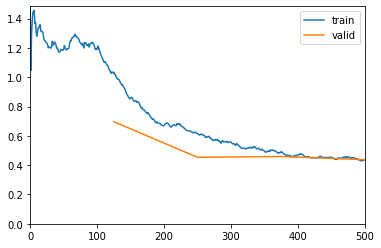

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.222888,0.428180,0.193333,0.806667,0.768333,00:07
1,0.128178,0.416126,0.206667,0.793333,0.790000,00:07
2,0.089288,0.479116,0.186667,0.813333,0.757500,00:07
3,0.361174,0.466903,0.173333,0.826667,0.763889,00:07
4,0.384193,0.494855,0.180000,0.820000,0.741667,00:07
5,0.387452,0.439840,0.173333,0.826667,0.763889,00:07
6,0.365018,0.467894,0.186667,0.813333,0.776667,00:07
7,0.345512,0.461391,0.173333,0.826667,0.749167,00:07
8,0.335087,0.461260,0.166667,0.833333,0.777778,00:07
9,0.310138,0.471101,0.173333,0.826667,0.760000,00:07


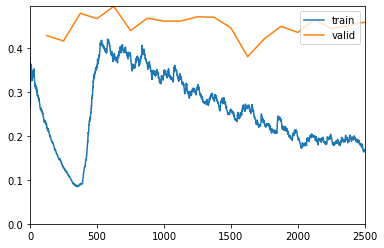

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.055800,0.881661,0.286667,0.713333,0.538333,00:05
1,0.638980,0.554036,0.233333,0.766667,0.668056,00:05
2,0.474793,0.473336,0.193333,0.806667,0.756389,00:05
3,0.416196,0.458007,0.193333,0.806667,0.762778,00:05


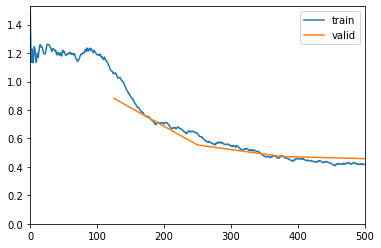

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.191208,0.450357,0.206667,0.793333,0.765556,00:07
1,0.139996,0.476757,0.186667,0.813333,0.751945,00:07
2,0.086847,0.515870,0.193333,0.806667,0.741111,00:07
3,0.341743,0.470033,0.180000,0.820000,0.776667,00:07
4,0.366648,0.426030,0.166667,0.833333,0.795278,00:07
5,0.367698,0.417487,0.180000,0.820000,0.800278,00:07
6,0.356082,0.465319,0.213333,0.786667,0.774167,00:07
7,0.333657,0.511754,0.226667,0.773333,0.733056,00:07
8,0.322197,0.447410,0.153333,0.846667,0.809167,00:07
9,0.312375,0.429038,0.180000,0.820000,0.823333,00:07


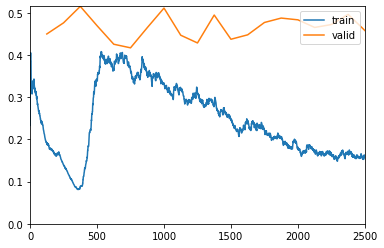

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.052629,0.659062,0.220000,0.780000,0.681944,00:05
1,0.604482,0.534674,0.220000,0.780000,0.720833,00:05
2,0.476999,0.550137,0.200000,0.800000,0.726667,00:05
3,0.440897,0.529326,0.206667,0.793333,0.755278,00:05


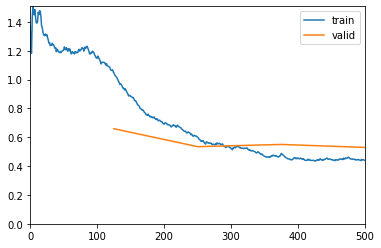

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.208301,0.512583,0.200000,0.800000,0.761111,00:07
1,0.117417,0.491064,0.200000,0.800000,0.776389,00:07
2,0.077142,0.626194,0.200000,0.800000,0.740000,00:07
3,0.372881,0.652971,0.213333,0.786667,0.717500,00:07
4,0.389974,0.526769,0.186667,0.813333,0.735000,00:07
5,0.365979,0.468962,0.186667,0.813333,0.788333,00:07
6,0.350532,0.569258,0.193333,0.806667,0.712778,00:07
7,0.356881,0.536407,0.206667,0.793333,0.746944,00:07
8,0.356899,0.527055,0.193333,0.806667,0.790833,00:07
9,0.329069,0.491290,0.193333,0.806667,0.803889,00:07


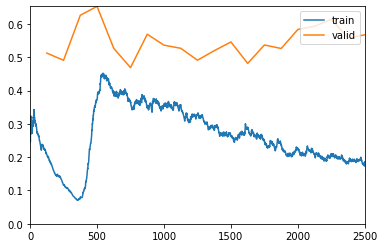

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.043179,0.626827,0.220000,0.780000,0.710833,00:05
1,0.642110,0.491554,0.180000,0.820000,0.733056,00:05
2,0.496343,0.462844,0.213333,0.786667,0.800833,00:05
3,0.419210,0.419964,0.200000,0.800000,0.820278,00:05


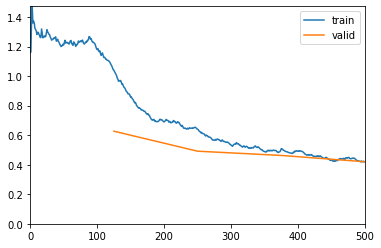

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.200502,0.427529,0.193333,0.806667,0.815000,00:07
1,0.134550,0.453753,0.193333,0.806667,0.804722,00:07
2,0.080035,0.493031,0.193333,0.806667,0.802222,00:07
3,0.344994,0.442909,0.180000,0.820000,0.807222,00:07
4,0.372427,0.429120,0.166667,0.833333,0.781944,00:07
5,0.365415,0.415767,0.173333,0.826667,0.804722,00:07
6,0.357220,0.496816,0.173333,0.826667,0.776944,00:07
7,0.366651,0.503823,0.173333,0.826667,0.755833,00:07
8,0.314898,0.519154,0.180000,0.820000,0.800556,00:07
9,0.314024,0.493432,0.180000,0.820000,0.787500,00:07


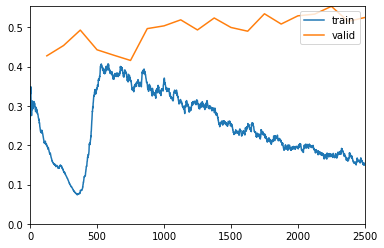

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.970695,0.745340,0.273333,0.726667,0.607500,00:05
1,0.604392,0.523041,0.220000,0.780000,0.653611,00:05
2,0.468875,0.451660,0.173333,0.826667,0.744722,00:05
3,0.432273,0.463896,0.200000,0.800000,0.733889,00:05


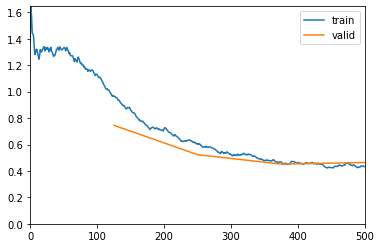

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.222951,0.444002,0.186667,0.813333,0.762778,00:07
1,0.124588,0.453043,0.193333,0.806667,0.753611,00:07
2,0.080871,0.477874,0.206667,0.793333,0.762222,00:07
3,0.344326,0.483707,0.193333,0.806667,0.748333,00:07
4,0.394639,0.459936,0.180000,0.820000,0.773056,00:07
5,0.398182,0.471274,0.186667,0.813333,0.770833,00:07
6,0.388676,0.469685,0.186667,0.813333,0.762222,00:07
7,0.364725,0.446631,0.166667,0.833333,0.791945,00:07
8,0.348715,0.482839,0.173333,0.826667,0.783611,00:07
9,0.321937,0.463381,0.186667,0.813333,0.775833,00:07


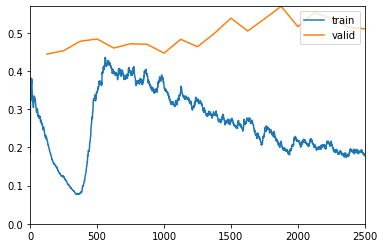

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.020686,0.627953,0.253333,0.746667,0.614167,00:05
1,0.582563,0.556796,0.193333,0.806667,0.681667,00:05
2,0.493412,0.433435,0.180000,0.820000,0.781944,00:05
3,0.422816,0.455879,0.200000,0.800000,0.760000,00:05


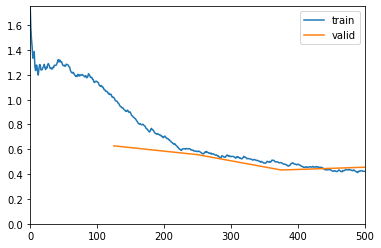

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.217517,0.433333,0.180000,0.820000,0.790278,00:07
1,0.125614,0.447534,0.200000,0.800000,0.786389,00:07
2,0.085599,0.505665,0.200000,0.800000,0.770278,00:07
3,0.338233,0.533112,0.206667,0.793333,0.713056,00:07
4,0.389429,0.440830,0.166667,0.833333,0.770000,00:07
5,0.380591,0.467778,0.193333,0.806667,0.767500,00:07
6,0.356807,0.461263,0.200000,0.800000,0.766944,00:07
7,0.360500,0.449364,0.200000,0.800000,0.807500,00:07
8,0.336909,0.463649,0.153333,0.846667,0.798333,00:07
9,0.293156,0.404961,0.166667,0.833333,0.835556,00:07


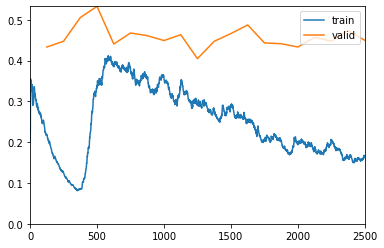

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.991334,0.698013,0.233333,0.766667,0.656667,00:05
1,0.605223,0.608871,0.200000,0.800000,0.603056,00:05
2,0.487706,0.513852,0.166667,0.833333,0.710278,00:05
3,0.429262,0.481891,0.180000,0.820000,0.739167,00:05


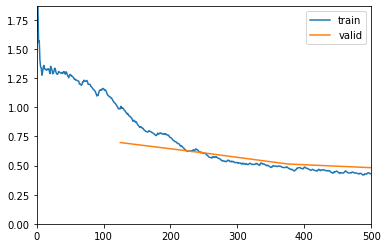

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.209256,0.481293,0.173333,0.826667,0.745000,00:07
1,0.132692,0.538836,0.180000,0.820000,0.714722,00:07
2,0.082020,0.573523,0.173333,0.826667,0.721667,00:07
3,0.361271,0.511511,0.160000,0.840000,0.740278,00:07
4,0.417198,0.494832,0.180000,0.820000,0.765833,00:07
5,0.394178,0.528938,0.193333,0.806667,0.768333,00:07
6,0.375234,0.515799,0.206667,0.793333,0.744167,00:07
7,0.373245,0.510725,0.173333,0.826667,0.763611,00:07
8,0.349503,0.546439,0.193333,0.806667,0.764167,00:07
9,0.309281,0.526456,0.173333,0.826667,0.778889,00:07


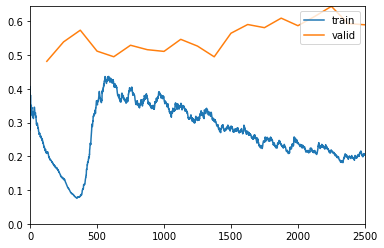

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.015083,0.765655,0.260000,0.740000,0.666667,00:05
1,0.611936,0.546023,0.200000,0.800000,0.668889,00:05
2,0.481137,0.426159,0.173333,0.826667,0.803056,00:05
3,0.416715,0.437132,0.180000,0.820000,0.811944,00:05


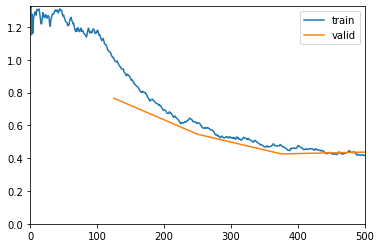

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.187726,0.426509,0.180000,0.820000,0.811111,00:07
1,0.118375,0.412128,0.160000,0.840000,0.828333,00:07
2,0.077099,0.473127,0.160000,0.840000,0.803611,00:07
3,0.340205,0.487127,0.166667,0.833333,0.798889,00:07
4,0.376130,0.471097,0.180000,0.820000,0.790556,00:07
5,0.408956,0.488896,0.180000,0.820000,0.775833,00:07
6,0.365575,0.601259,0.213333,0.786667,0.726389,00:07
7,0.365947,0.519790,0.193333,0.806667,0.792500,00:07
8,0.334253,0.507653,0.193333,0.806667,0.799444,00:07
9,0.306720,0.490889,0.193333,0.806667,0.792500,00:07


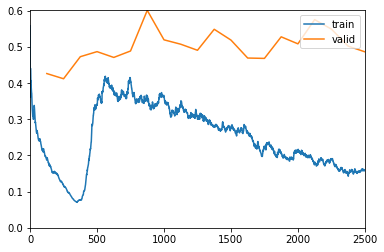

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.965685,0.737731,0.273333,0.726667,0.760833,00:05
1,0.617154,0.598581,0.246667,0.753333,0.603889,00:05
2,0.475016,0.486527,0.200000,0.800000,0.694722,00:05
3,0.432698,0.432851,0.173333,0.826667,0.774444,00:05


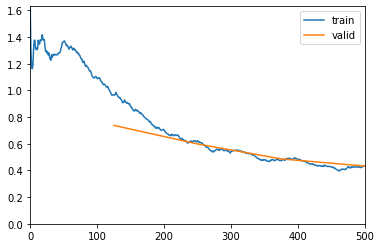

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.204088,0.437497,0.186667,0.813333,0.763889,00:07
1,0.123619,0.436928,0.166667,0.833333,0.771389,00:07
2,0.076822,0.511383,0.180000,0.820000,0.717500,00:07
3,0.371515,0.467732,0.173333,0.826667,0.783889,00:07
4,0.382132,0.467088,0.193333,0.806667,0.787222,00:07
5,0.362692,0.492903,0.193333,0.806667,0.777778,00:07
6,0.359162,0.428021,0.166667,0.833333,0.804444,00:07
7,0.356811,0.404269,0.186667,0.813333,0.819167,00:07
8,0.334495,0.456300,0.160000,0.840000,0.799722,00:07
9,0.295124,0.402440,0.140000,0.860000,0.844167,00:07


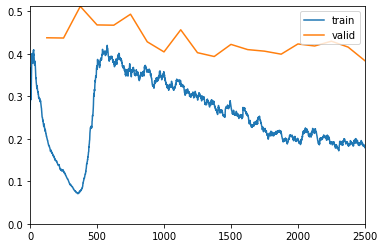

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.955399,0.606973,0.186667,0.813333,0.770556,00:05
1,0.603042,0.572527,0.246667,0.753333,0.643056,00:05
2,0.469490,0.496395,0.193333,0.806667,0.695278,00:05
3,0.437939,0.470545,0.186667,0.813333,0.744167,00:05


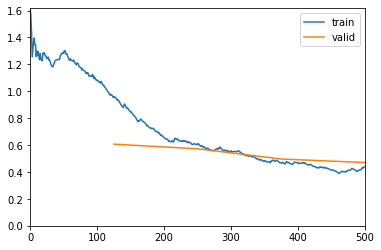

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.205335,0.449176,0.173333,0.826667,0.773611,00:07
1,0.114642,0.466614,0.153333,0.846667,0.769445,00:07
2,0.086058,0.529636,0.180000,0.820000,0.714444,00:07
3,0.358433,0.521457,0.186667,0.813333,0.760833,00:07
4,0.376680,0.482008,0.193333,0.806667,0.768333,00:07
5,0.356173,0.465355,0.213333,0.786667,0.786945,00:07
6,0.348450,0.445375,0.173333,0.826667,0.796111,00:07
7,0.353412,0.454025,0.213333,0.786667,0.800833,00:07
8,0.321076,0.438470,0.173333,0.826667,0.816389,00:07
9,0.298436,0.384205,0.153333,0.846667,0.852222,00:07


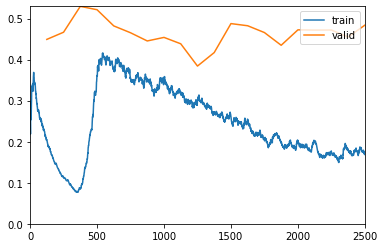

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.985082,0.761754,0.240000,0.760000,0.668333,00:05
1,0.604776,0.648990,0.253333,0.746667,0.585278,00:05
2,0.476941,0.478433,0.193333,0.806667,0.747222,00:05
3,0.434823,0.445292,0.173333,0.826667,0.797222,00:05


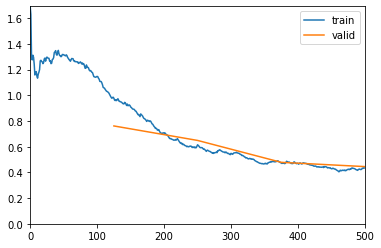

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.204894,0.454566,0.206667,0.793333,0.797222,00:07
1,0.127552,0.500261,0.180000,0.820000,0.764167,00:07
2,0.081302,0.558075,0.186667,0.813333,0.753889,00:07
3,0.377107,0.594862,0.186667,0.813333,0.760833,00:07
4,0.383091,0.568416,0.193333,0.806667,0.796667,00:07
5,0.371571,0.508219,0.193333,0.806667,0.809444,00:07
6,0.353848,0.544004,0.180000,0.820000,0.763333,00:07
7,0.365461,0.517725,0.206667,0.793333,0.776389,00:07
8,0.343682,0.538364,0.186667,0.813333,0.758056,00:07
9,0.312174,0.514636,0.173333,0.826667,0.796944,00:07


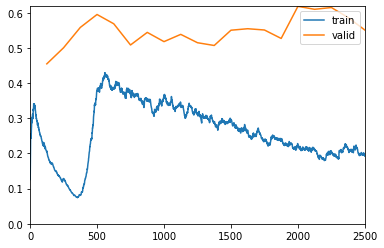

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.988047,0.561385,0.200000,0.800000,0.774722,00:05
1,0.589316,0.512793,0.200000,0.800000,0.731667,00:05
2,0.477562,0.427801,0.206667,0.793333,0.772778,00:05
3,0.438343,0.434845,0.166667,0.833333,0.784722,00:05


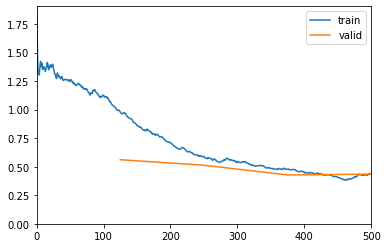

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.190143,0.437487,0.173333,0.826667,0.777222,00:07
1,0.114553,0.452982,0.200000,0.800000,0.775833,00:07
2,0.081693,0.496748,0.186667,0.813333,0.761389,00:07
3,0.363321,0.579339,0.173333,0.826667,0.755833,00:07
4,0.387938,0.490255,0.193333,0.806667,0.786389,00:07
5,0.363870,0.514219,0.206667,0.793333,0.772222,00:07
6,0.377931,0.420800,0.193333,0.806667,0.816389,00:07
7,0.336780,0.434372,0.180000,0.820000,0.824444,00:07
8,0.330863,0.491449,0.166667,0.833333,0.817778,00:07
9,0.279828,0.474134,0.186667,0.813333,0.808611,00:07


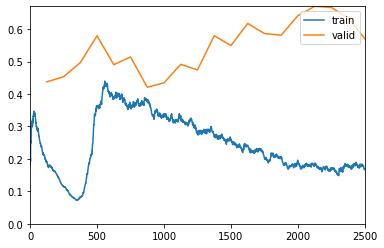

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.050066,0.684315,0.306667,0.693333,0.649167,00:05
1,0.592035,0.492914,0.220000,0.780000,0.688333,00:05
2,0.490015,0.466400,0.186667,0.813333,0.731389,00:05
3,0.436625,0.438419,0.186667,0.813333,0.745555,00:05


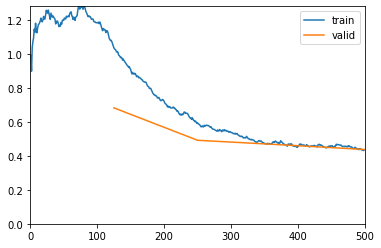

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.191920,0.434761,0.173333,0.826667,0.750833,00:07
1,0.123206,0.459410,0.193333,0.806667,0.722778,00:07
2,0.082774,0.513025,0.200000,0.800000,0.718333,00:07
3,0.388758,0.446665,0.160000,0.840000,0.786111,00:07
4,0.395054,0.444532,0.193333,0.806667,0.791389,00:07
5,0.394856,0.471246,0.193333,0.806667,0.796389,00:07
6,0.357678,0.464337,0.173333,0.826667,0.751389,00:07
7,0.353666,0.425097,0.153333,0.846667,0.804722,00:07
8,0.341232,0.372188,0.153333,0.846667,0.846389,00:07
9,0.310011,0.457469,0.160000,0.840000,0.775278,00:07


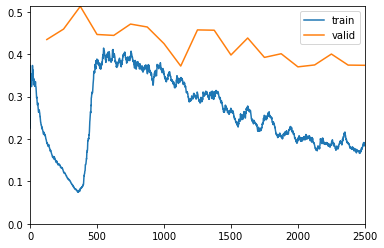

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.080988,0.768685,0.306667,0.693333,0.657500,00:05
1,0.570783,0.677991,0.260000,0.740000,0.591667,00:05
2,0.482251,0.545352,0.193333,0.806667,0.683333,00:05
3,0.426083,0.505614,0.186667,0.813333,0.695833,00:05


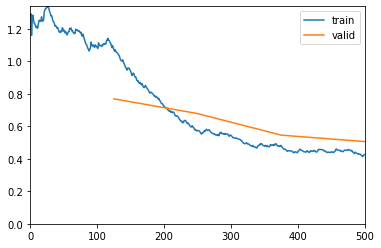

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.194465,0.511388,0.180000,0.820000,0.701111,00:07
1,0.112502,0.507492,0.200000,0.800000,0.724444,00:07
2,0.078903,0.585019,0.213333,0.786667,0.698611,00:07
3,0.381627,0.543663,0.193333,0.806667,0.721945,00:07
4,0.408716,0.473229,0.173333,0.826667,0.762500,00:07
5,0.395654,0.455652,0.186667,0.813333,0.769722,00:07
6,0.366681,0.445554,0.180000,0.820000,0.772222,00:07
7,0.331405,0.444351,0.166667,0.833333,0.775556,00:07
8,0.317086,0.472487,0.166667,0.833333,0.779722,00:07
9,0.303181,0.464873,0.166667,0.833333,0.802222,00:07


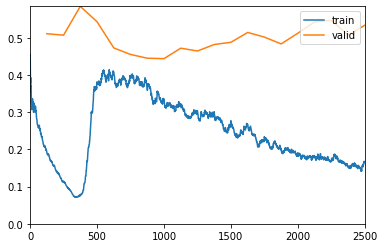

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.097111,0.851007,0.233333,0.766667,0.568889,00:05
1,0.597682,0.568155,0.200000,0.800000,0.682778,00:05
2,0.502545,0.510717,0.193333,0.806667,0.694444,00:05
3,0.434674,0.485701,0.180000,0.820000,0.733889,00:05


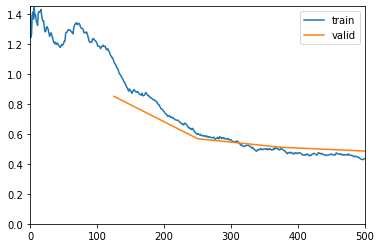

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.210362,0.496406,0.180000,0.820000,0.730833,00:07
1,0.139898,0.497370,0.173333,0.826667,0.723889,00:07
2,0.092736,0.579969,0.180000,0.820000,0.680278,00:07
3,0.365114,0.508886,0.193333,0.806667,0.788611,00:07
4,0.400338,0.507173,0.160000,0.840000,0.760556,00:07
5,0.417604,0.489641,0.193333,0.806667,0.786389,00:07
6,0.363123,0.490031,0.186667,0.813333,0.790278,00:07
7,0.344980,0.498814,0.180000,0.820000,0.786945,00:07
8,0.334651,0.548823,0.193333,0.806667,0.777222,00:07
9,0.303953,0.533376,0.186667,0.813333,0.780278,00:07


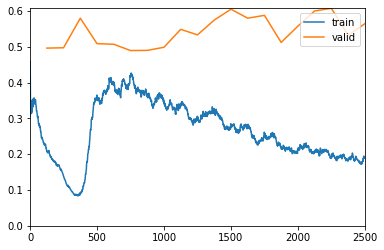

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.021402,0.859156,0.220000,0.780000,0.594444,00:05
1,0.606082,0.516380,0.200000,0.800000,0.712778,00:05
2,0.485064,0.528241,0.213333,0.786667,0.711389,00:05
3,0.438928,0.464765,0.206667,0.793333,0.772222,00:09


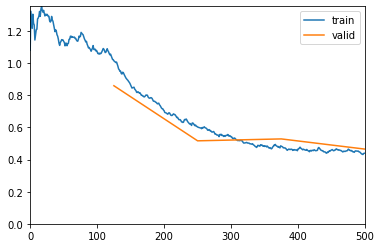

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.219486,0.494208,0.193333,0.806667,0.778333,00:16
1,0.119245,0.460702,0.193333,0.806667,0.796667,00:14
2,0.087330,0.508054,0.180000,0.820000,0.784444,00:12
3,0.364807,0.497253,0.173333,0.826667,0.780556,00:13
4,0.412626,0.431234,0.166667,0.833333,0.815833,00:13
5,0.399841,0.487433,0.213333,0.786667,0.745000,00:13
6,0.365306,0.446672,0.186667,0.813333,0.780833,00:13
7,0.343070,0.497961,0.173333,0.826667,0.776667,00:13
8,0.323004,0.491985,0.186667,0.813333,0.780833,00:13
9,0.317088,0.499814,0.200000,0.800000,0.791667,00:13


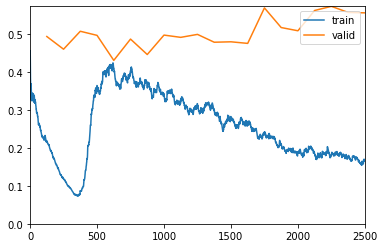

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.058054,0.774672,0.293333,0.706667,0.625000,00:06
1,0.617894,0.524359,0.246667,0.753333,0.736944,00:05
2,0.480505,0.445598,0.186667,0.813333,0.727500,00:05
3,0.421138,0.412032,0.160000,0.840000,0.786945,00:05


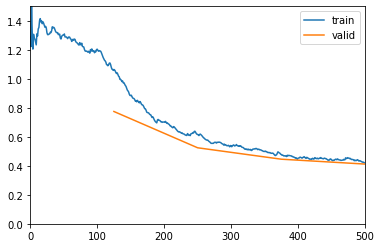

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.200256,0.417976,0.193333,0.806667,0.791667,00:07
1,0.126754,0.426469,0.186667,0.813333,0.782778,00:07
2,0.091443,0.441833,0.173333,0.826667,0.761944,00:07
3,0.340097,0.505609,0.206667,0.793333,0.746389,00:07
4,0.401305,0.492825,0.166667,0.833333,0.753611,00:07
5,0.396466,0.524269,0.193333,0.806667,0.739444,00:07
6,0.355811,0.449258,0.186667,0.813333,0.797222,00:07
7,0.340998,0.535216,0.213333,0.786667,0.725000,00:07
8,0.335342,0.444847,0.193333,0.806667,0.788889,00:07
9,0.307626,0.467507,0.160000,0.840000,0.780833,00:07


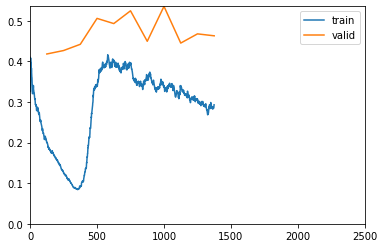

In [ ]:
seeds = range(1,11)
epochs = 20

for seed in seeds:
    
    #Baseline
    data = reload_dataset(dm,seed=seed)    
    baseline_accs = train_and_return_metrics(data,seed,epochs)

    
    #With segmentation
    data = reload_dataset(dm,segmented=True, seed=seed)
    segmented_accs = train_and_return_metrics(data,seed,epochs)
    
    
    #Baseline + Shades of Gray
    data = reload_dataset(dm,seed=seed) 
    add_shades_of_gray(data)
    baseline_sog_accs = train_and_return_metrics(data,seed,epochs)
    
    #segmentation + Shades of Gray
    data = reload_dataset(dm,segmented=True, seed=seed)   
    add_shades_of_gray(data)
    segmented_sog_accs = train_and_return_metrics(data,seed,epochs)
    
    
    
    
    write_results(seed, baseline_accs, segmented_accs,baseline_sog_accs,segmented_sog_accs)
    

# Analyze results

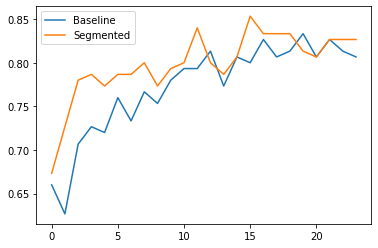

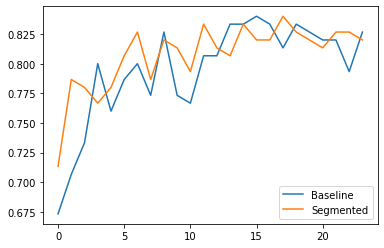

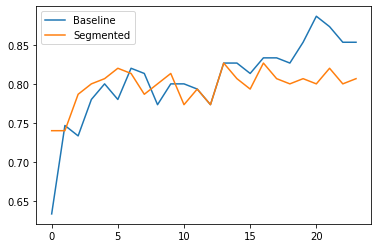

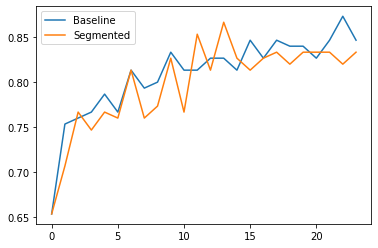

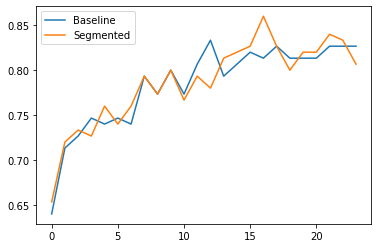

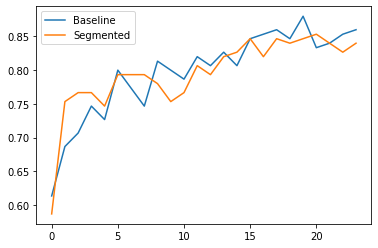

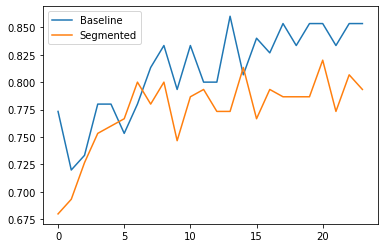

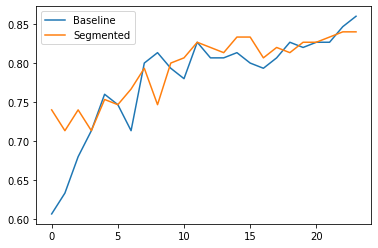

In [98]:
runs = {}
for i in range(1,9):
    runs[i] = pd.read_csv(f'{results_file_name}_{i}.txt')
    runs[i].plot()

In [99]:
max_acc_for_each_run_baseline = [runs[r].max()['Baseline'] for r in runs]
max_acc_for_each_run_segmented = [runs[r].max()['Segmented'] for r in runs]


In [100]:
df = pd.DataFrame({
                    'Baseline':max_acc_for_each_run_baseline,
                    'Segmented': max_acc_for_each_run_segmented
                })

In [101]:
df.describe()

,Baseline,Segmented
count,8.000000,8.000000
mean,0.858333,0.845000
std,0.021006,0.016232
min,0.833333,0.820000
25%,0.838333,0.836667
50%,0.860000,0.846667
75%,0.875000,0.855000
max,0.886667,0.866667


In [102]:
times_max_rgb_had_higher_acc = [runs[i].max()['Baseline'] < runs[i].max()['Segmented'] for i in runs]

arl_effectiveness = sum(times_max_rgb_had_higher_acc)/ len(runs)

print(f'Segmentation improved the Accuracy in {arl_effectiveness*100}% of the cases')

Segmentation improved the Accuracy in 25.0% of the cases
